In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [25]:
df = pd.read_csv('vocal_gender_features_new.csv')

In [26]:
X = df.drop('label', axis=1)
y = df['label']

In [27]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)


In [28]:
# Normalize numerical features using StandardScaler
# Fit scaler only on the training data to prevent data leakage
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


In [29]:
# Convert scaled arrays back to DataFrames (optional, but good for consistency)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=X.columns, index=X_val.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

print("Data loaded, split, and scaled successfully.")
print(f"Original number of features: {X_train_scaled_df.shape[1]}")

Data loaded, split, and scaled successfully.
Original number of features: 43


# --- 1. Processing Pipeline: Dimensionality Reduction (PCA) ---
# PCA is used to reduce the number of features while retaining most of the variance.
# This can help with model performance (speed, generalization) and reduce overfitting.
# We'll choose a number of components that explains a significant portion of variance (e.g., 95%)
# Or, you can set a fixed number of components. Let's start with a fixed number for demonstration.


In [30]:
# Initialize PCA - let's aim for 10 principal components as an example
# You can analyze explained variance ratio to choose an optimal number.
n_components = 10 # Example: reduce to 10 principal components
pca = PCA(n_components=n_components, random_state=42)


In [31]:
# Fit PCA only on the training data and transform all sets
X_train_pca = pca.fit_transform(X_train_scaled_df)
X_val_pca = pca.transform(X_val_scaled_df)
X_test_pca = pca.transform(X_test_scaled_df)


In [32]:
print(f"\n--- Dimensionality Reduction (PCA) ---")
print(f"Number of components selected: {n_components}")
print(f"Explained variance ratio by selected components: {pca.explained_variance_ratio_.sum():.2f}")
print(f"X_train_pca shape: {X_train_pca.shape}")
print(f"X_val_pca shape: {X_val_pca.shape}")
print(f"X_test_pca shape: {X_test_pca.shape}")



--- Dimensionality Reduction (PCA) ---
Number of components selected: 10
Explained variance ratio by selected components: 0.72
X_train_pca shape: (11303, 10)
X_val_pca shape: (2422, 10)
X_test_pca shape: (2423, 10)


# --- 2. Model Training ---

In [33]:
print("\n--- Model Training ---")


--- Model Training ---


In [34]:
# --- Model 1: Random Forest Classifier ---

print("\nTraining Random Forest Classifier...")
# RandomForest is an ensemble method that builds multiple decision trees.
# It's robust to overfitting and works well with many features.
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1) # n_jobs=-1 uses all available cores
rf_model.fit(X_train_pca, y_train)
print("Random Forest training complete.")


Training Random Forest Classifier...
Random Forest training complete.


In [35]:
# Evaluate Random Forest on the validation set
y_val_pred_rf = rf_model.predict(X_val_pca)
rf_accuracy = accuracy_score(y_val, y_val_pred_rf)
print(f"Random Forest Validation Accuracy: {rf_accuracy:.4f}")
print("Random Forest Classification Report (Validation Set):\n", classification_report(y_val, y_val_pred_rf))


Random Forest Validation Accuracy: 0.9851
Random Forest Classification Report (Validation Set):
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       865
           1       0.99      0.99      0.99      1557

    accuracy                           0.99      2422
   macro avg       0.98      0.98      0.98      2422
weighted avg       0.99      0.99      0.99      2422



In [36]:
# --- Model 2: Support Vector Machine (SVM) ---
print("\nTraining Support Vector Machine (SVM)...")
# SVMs are powerful for classification by finding the optimal hyperplane that separates classes.
# They can be computationally intensive for large datasets.
svm_model = SVC(kernel='rbf', random_state=42, probability=True) # 'rbf' (Radial Basis Function) is a common kernel
svm_model.fit(X_train_pca, y_train)
print("SVM training complete.")



Training Support Vector Machine (SVM)...
SVM training complete.


In [37]:
# Evaluate SVM on the validation set
y_val_pred_svm = svm_model.predict(X_val_pca)
svm_accuracy = accuracy_score(y_val, y_val_pred_svm)
print(f"SVM Validation Accuracy: {svm_accuracy:.4f}")
print("SVM Classification Report (Validation Set):\n", classification_report(y_val, y_val_pred_svm))


SVM Validation Accuracy: 0.9897
SVM Classification Report (Validation Set):
               precision    recall  f1-score   support

           0       0.99      0.98      0.99       865
           1       0.99      0.99      0.99      1557

    accuracy                           0.99      2422
   macro avg       0.99      0.99      0.99      2422
weighted avg       0.99      0.99      0.99      2422



In [38]:
# --- Model Evaluation and Comparison (on Test Set) ---
print("\n--- Model Evaluation on Test Set ---")



--- Model Evaluation on Test Set ---


In [39]:
# Select the best performing model based on validation accuracy
if rf_accuracy >= svm_accuracy:
    best_model = rf_model
    best_model_name = "Random Forest"
    X_test_final = X_test_pca
    y_test_final = y_test
else:
    best_model = svm_model
    best_model_name = "SVM"
    X_test_final = X_test_pca
    y_test_final = y_test

print(f"\nBest model based on validation accuracy: {best_model_name}")

y_test_pred = best_model.predict(X_test_final)



Best model based on validation accuracy: SVM


In [40]:
# Calculate evaluation metrics
test_accuracy = accuracy_score(y_test_final, y_test_pred)
test_precision = precision_score(y_test_final, y_test_pred, average='weighted')
test_recall = recall_score(y_test_final, y_test_pred, average='weighted')
test_f1 = f1_score(y_test_final, y_test_pred, average='weighted')
conf_matrix = confusion_matrix(y_test_final, y_test_pred)


In [41]:
print(f"\n{best_model_name} Test Accuracy: {test_accuracy:.4f}")
print(f"{best_model_name} Test Precision: {test_precision:.4f}")
print(f"{best_model_name} Test Recall: {test_recall:.4f}")
print(f"{best_model_name} Test F1-Score: {test_f1:.4f}")
print(f"\n{best_model_name} Confusion Matrix:\n", conf_matrix)


SVM Test Accuracy: 0.9926
SVM Test Precision: 0.9926
SVM Test Recall: 0.9926
SVM Test F1-Score: 0.9926

SVM Confusion Matrix:
 [[ 858    8]
 [  10 1547]]


Saved 'svm_confusion_matrix.png'.

Classification Report for SVM (Test Set):
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       866
           1       0.99      0.99      0.99      1557

    accuracy                           0.99      2423
   macro avg       0.99      0.99      0.99      2423
weighted avg       0.99      0.99      0.99      2423



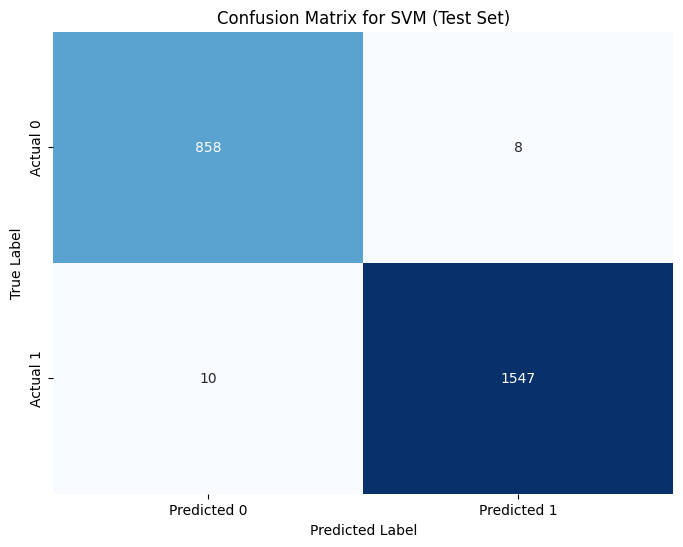

In [42]:
# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title(f'Confusion Matrix for {best_model_name} (Test Set)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig(f'{best_model_name.lower().replace(" ", "_")}_confusion_matrix.png')
print(f"Saved '{best_model_name.lower().replace(' ', '_')}_confusion_matrix.png'.")

print(f"\nClassification Report for {best_model_name} (Test Set):\n", classification_report(y_test_final, y_test_pred))


In [43]:
# --- 3. Save Trained Models ---
print("\n--- Saving Trained Models ---")



--- Saving Trained Models ---


In [44]:
# Save the StandardScaler
scaler_filename = 'scaler.joblib'
joblib.dump(scaler, scaler_filename)
print(f"StandardScaler saved as '{scaler_filename}'")

StandardScaler saved as 'scaler.joblib'


In [45]:
# Save the PCA model
pca_filename = 'pca.joblib'
joblib.dump(pca, pca_filename)
print(f"PCA model saved as '{pca_filename}'")


PCA model saved as 'pca.joblib'


In [46]:
# Save the best performing classification model
model_filename = f'{best_model_name.lower().replace(" ", "_")}_model.joblib'
joblib.dump(best_model, model_filename)
print(f"Best model ({best_model_name}) saved as '{model_filename}'")
# Save the training, validation, and test sets
train_data_filename = 'train_data.csv'
train_data = pd.DataFrame(X_train_pca, columns=[f'PC{i+1}' for i in range(X_train_pca.shape[1])])
train_data['label'] = y_train.reset_index(drop=True)

Best model (SVM) saved as 'svm_model.joblib'
